In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from sklearn.metrics import f1_score
import time

In [ ]:
df = pd.read_csv("drug_consumption.csv")

# Présentation du Dataset 

In [ ]:
df.tail()

,Id,Age,Gender,Education,Country,Ethnicity,Neuroticism,Escore,Oscore,Ascore,Cscore,Impulsivity,Sensation Seeking,Alcohol,Amphetamine,Amyl nitrite,Benzodiazepine,Caffeine,Cannabis,Chocolat,Cocaine,Crack,Ecstasy,Heroin,Ketamine,Legal high,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
1880,1884,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,CL5,CL0,CL0,CL0,CL4,CL5,CL4,CL0,CL0,CL0,CL0,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5
1881,1885,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,CL5,CL0,CL0,CL0,CL5,CL3,CL4,CL0,CL0,CL2,CL0,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0
1882,1886,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,CL4,CL6,CL5,CL5,CL6,CL6,CL6,CL4,CL0,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1883,1887,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,CL5,CL0,CL0,CL0,CL6,CL6,CL5,CL0,CL0,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0
1884,1888,-0.95197,-0.48246,-0.61113,0.21128,-0.31685,-0.46725,2.12700,1.65653,1.11406,0.41594,0.88113,1.22470,CL4,CL3,CL0,CL3,CL6,CL3,CL6,CL3,CL0,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL6,CL0,CL2


# Présentation de la problématique :


The aim of the project is to predict whether a person has an 'addictive' personality and therefore whether they are likely to be addicted to an illegal substance.

Our original dataset gives us information on the degree of addiction of individuals to different substances (legal and non-legal). The notation used is
- CL0: The person has never used.
- CL1: Person used over a decade ago.
- CL {2,3,4,5,6}: for uses at different frequencies, which we are going to confuse within the framework of this project.

We are only looking at illegal substances.

The pre-processing part will therefore consist of:
1. Identify illegal substances and keep only those in the table (nicotine, alcohol and benzodiazepine are removed).
2. Remove individuals who did not respond with CL0 to the Semer substance which is just an invention to detect people who 'say too much'.
3. Add an 'Addict' column with 1s and 0s to differentiate between people who are addicted to one of the substances determined in the first step and those who have never used any CL0 substance or who have used a few years ago. over a CL1 decade (maybe just to try and so presume it wasn't an addiction).

#Pré-traitement :

In [ ]:
df = pd.read_csv("drug_consumption.csv")

# Etape 1 
illegal_sub = ['Amphetamine', 'Amyl nitrite',
       'Cannabis', 'Cocaine',
       'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'LSD', 'Meth',
       'Mushrooms', 'Semer']

all_sub = set(list(df.columns[13:]))
ill_sub = set(illegal_sub)
drop_sub = all_sub-ill_sub

df = df.drop(columns=drop_sub)


# Etape 2
df = df[df['Semer'] == 'CL0']
df = df.drop(columns= ['Semer', 'Id'])
ill_sub.remove('Semer')


# Etape 3
def is_addict(row):
    add = 0
    for sub in ill_sub :
        if row[sub] != 'CL0' and row[sub] != 'CL1':
              add = 1
              break
    return add
  

df['isAddict'] = df.apply(lambda row : is_addict(row), axis = 1)
df = df.drop(columns = ill_sub)
df = df.reset_index(drop = True)

In [ ]:
df.to_csv('drug_use.csv', index = False)


In [96]:
df = pd.read_csv("drug_use.csv")

In [ ]:
labels_education = ['Left school before 16 years (1.49%)','Left school at 16 years(5.25%)' , 'Left school at 17 years (1.59%)','Left school at 18 years(5.31%)',
 'Some college or university,\n no certificate or degree (26.84%)', 'Professional certificate/ diploma(14.32%)','University degree(25.46%)'
 ,' Masters degree(15.01%)',' Doctorate degree(4.72%)']

labels_age = ['18-24(34.11%)','25-34(25.52%)', '35-44(18.89%)','45-54(15.60%)', '55-64(4.93%)','65+(0.95%)']

labels_gender = ['Male (50.03%)', 'Female (49.97%)']


# Data Exploration :

In [87]:
df.describe()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Escore,Oscore,Ascore,Cscore,Impulsivity,Sensation Seeking,isAddict
count,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000
mean,0.037577,-0.000771,-0.000984,0.358984,-0.309728,-0.000551,-0.001951,-0.003224,-0.000657,-0.000394,0.005293,-0.007408,0.707512
std,0.878387,0.482588,0.949831,0.699707,0.166220,0.998442,0.997418,0.995691,0.996689,0.997657,0.954148,0.962074,0.455026
min,-0.951970,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480,0.000000
25%,-0.951970,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930,0.000000
50%,-0.078540,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870,1.000000
75%,0.497880,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400,1.000000
max,2.591710,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730,1.000000


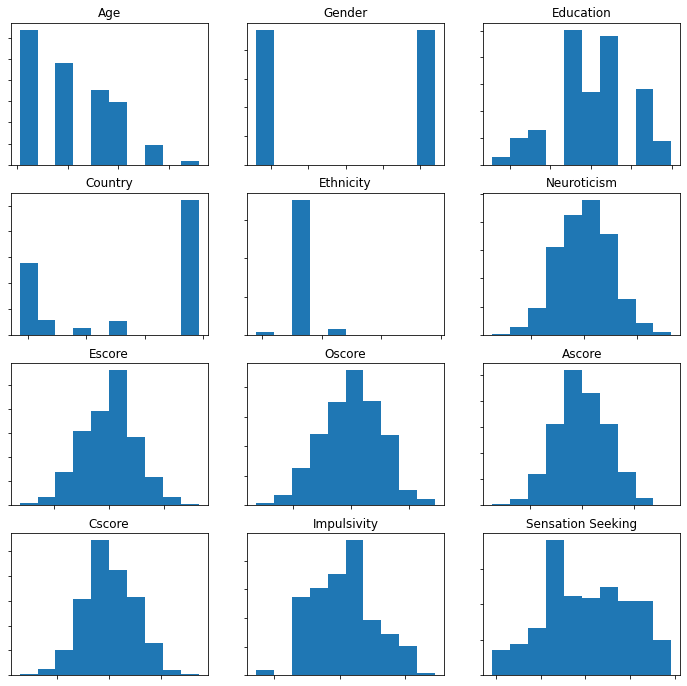

In [ ]:
pmax = 3
k = 0
plt.clf
plt.figure(figsize=(12,12))
for i in np.arange(0,4):
    for j in np.arange(0,3):
        k = k+1
        plt.subplot(4,3,k)
        plt.hist(df.to_numpy()[:,3*i+j])
        plt.axis('tight')
        # if i==1:
        plt.title(list(df.columns)[3*i+j])
        plt.tick_params(axis='x', labelbottom=False)
        plt.tick_params(axis='y', labelleft=False)

(array([ 549.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1328.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

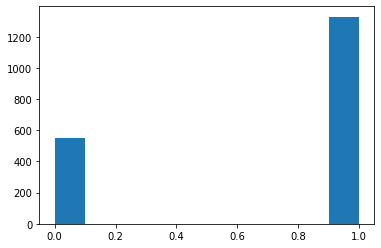

In [ ]:
plt.hist(df['isAddict'], label = ['Not addicted', 'Addicted'])

From the histograms, we notice the following :

- The data is skewed towards people that are addicted. Approximately 2/3 of our dataset is constituted from people that are using a type of illegal drugs.
- We also notice that all of the features have been categorised into buckets from more useful insight. We have a sparse setting where every person that took the survey had multiple choices to pick from.
- We also notice that the features that represents a personality trait (Escore, Oscore, Impulsivity ...) all seem to follow a gaussian distribution which is what we would expect from a non biased survey, that is extreme values are less likely to occur.
- We have as many females as males in this survey but younger people (most in category 1) are represented more in the dataset.

In [ ]:
def plot_hist(var, labels):
    # Prepare data
    x_var = var
    groupby_var = 'isAddict'
    df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
    vals = [df[x_var].values.tolist() for i, df in df_agg]

    d = {}
    k = 0
    for elt in sorted(list(set(df[var].to_numpy()))) :
      d[elt] = k
      k += 1

    v = []
    for g in vals:
      b = sorted(list(set(g)))
      tmp = []
      for elt in g :
        tmp.append(d[elt])
      v.append(tmp)

    plt.figure(figsize=(10,7), dpi= 80)
    colors = ['green', 'red']
    n, bins, patches = plt.hist(v, df[x_var].unique().__len__(), stacked=False, align = 'mid', density=False, color=colors[:len(v)])


    # Decoration
    plt.legend({group:col for group, col in zip(['Is not using','Is using'], colors[:len(v)])})
    plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
    plt.xlabel(x_var)
    plt.ylabel("Frequency")
    plt.xticks(ticks=bins+0.25, labels=labels, rotation=90)
    plt.imshow



# Analyse de la causalité entre certains attributs et l'addiction

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


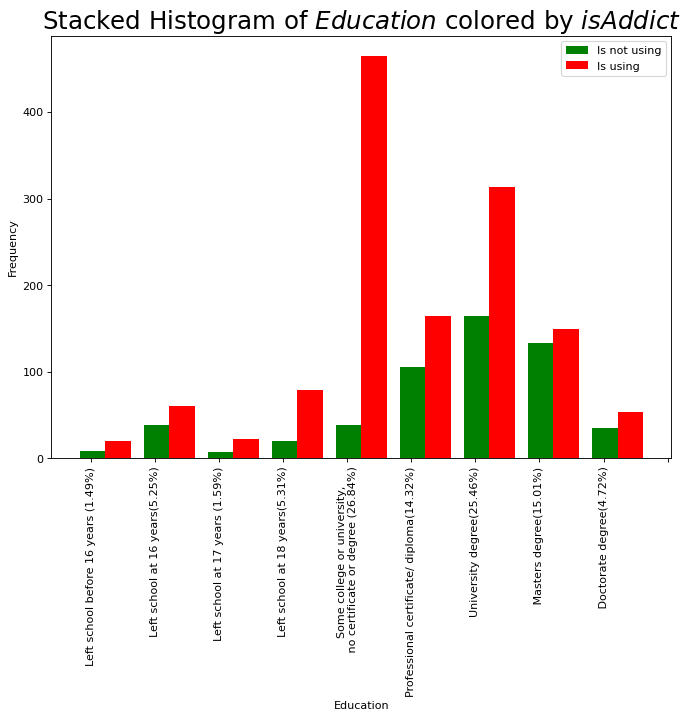

In [ ]:
 plot_hist('Education', labels_education)

**Analyse :**


Taking into account the prior on the number of people in every category, we should not directly compare the numbers as it is biased.
However, we can get some insight :
- The rate of using drops drastically between the category of people who had some college education without degree( college dropout) compared to those who have a university degree. Those categories having the same amount of people, this conclusion is not biaised.
- The greater the education the lower the ratio using/not-using

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


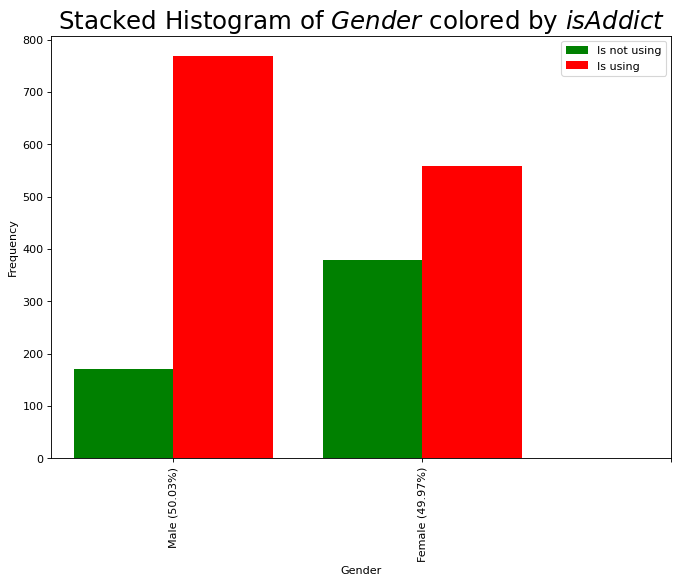

In [ ]:
plot_hist('Gender', labels_gender)

- Analysis :
Male consumes clearly more drugs than females. This will be confirmed later when doing Lasso feature selection.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


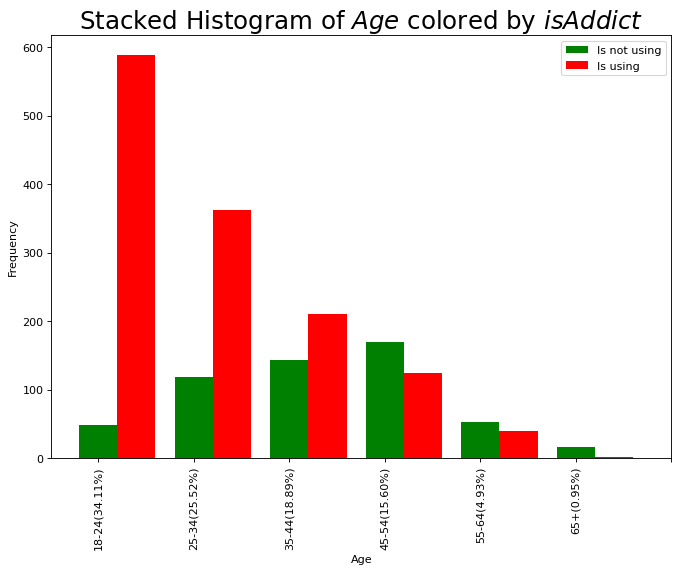

In [ ]:
plot_hist('Age', labels_age)

**Analysis**:
The number of people using decreases as the age of the individual is high. Young subjects (18-24yo) consume the most. While elder have minimal use rates.

# Analyse PCA et détermination de la séparabalité des données :

## PCA (dim = 2)

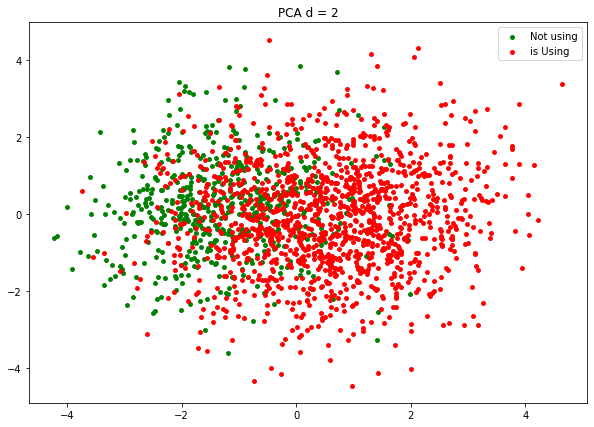

In [89]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

fig, ax = plt.subplots(figsize=(10,7))
X = df.drop('isAddict',1)
y = df['isAddict']
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)
cdict = {0: 'green', 1: 'red'}
y = np.choose(y, [0, 1]).astype(float)
for g in [0,1]:
    ix = np.where(y == g)
    ax.scatter(X[ix, 0], X[ix, 1], c=cdict[g],s=15)
plt.title('PCA d = 2')
plt.legend(['Not using', 'is Using'])
plt.show()

## PCA (dim = 3)

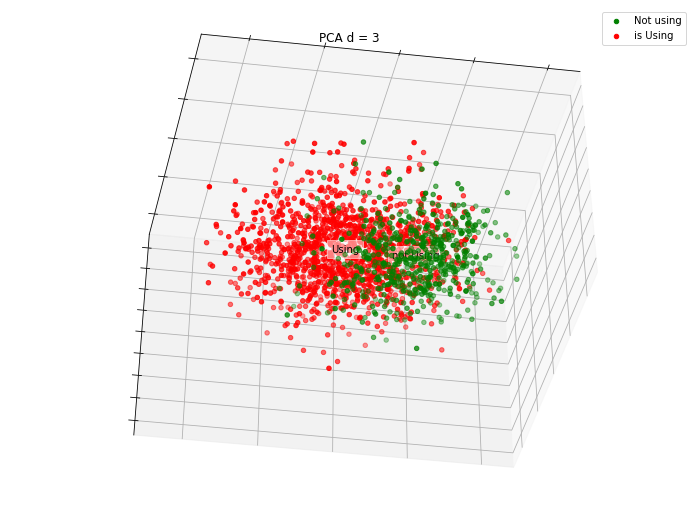

In [94]:


X = df.drop('isAddict',1)
y = df['isAddict']

fig = plt.figure(1, figsize=(10,7))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=-45, azim=80)

pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

cdict = {0: 'green', 1: 'red'}

for name, label in [('not Using', 0), ('Using', 1)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean(),
              X[y == label, 2].mean(),name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [0, 1]).astype(float)
for g in [0,1]:
    ix = np.where(y == g)
    ax.scatter(X[ix, 0], X[ix, 1], X[ix, 2], c=cdict[g])
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.title('PCA d = 3')
plt.legend(['Not using', 'is Using'])
plt.show()

**PCA**

The PCA graph shows us there is distinctive regions for every category. We can imagine there being a hyperplane separating the two clusters especially that in higher dimension the separation might be more performant that the 2-d case.

# Separation of our Data (TRAIN-VALIDATION-SPLIT)

In [97]:
df = pd.read_csv("drug_use.csv")
X = df.drop(columns=['isAddict']).to_numpy()
Y = df['isAddict'].to_numpy().reshape(-1,1)

tmp = np.concatenate((X,Y), axis = 1)
np.random.shuffle(tmp)
X, Y = tmp[:,:-1], tmp[:,-1]

X, X_val, X_test = X[:1400], X[1400:1700], X[1700:]
Y, Y_val, Y_test = Y[:1400], Y[1400:1700], Y[1700:]

# Presentation of our model :

On utilise le soft classier :
$$h_w(x) = \sigma (w^T x)$$

Le résultat de la classification étant :
$$
h_w(x) = 
     \begin{cases}
       \text{1} &\quad\text{if: }h_w(x) > \frac{1}{2}\\
       \text{0} &\quad\text{else}\\ 
     \end{cases}
     
$$

We consider the matrix X as our training data, Y as the training labels.

La fonction de perte choisie est la cross-entropie :

- $\tilde{f}(x,y,w) = -y\cdot log(\sigma (w^T x)) -(1-y)\cdot log(1-\sigma (w^T x))$ \\
- $f(w) = \frac{1}{N}sum(-Y \odot log(\sigma(w^T x^T)) - (1-Y)\odot log(1-\sigma(w^T X^T)))$

Le gradient de cette fonction par rapport à $w$, à chaque point, on a:
- $\nabla_w \tilde{f}(x,y,w) = -y \cdot x + x \cdot \sigma (w^T x) $ \\
Et donc $\nabla_w L(w) = \frac{1}{N} \sum_{i=1}^{N} -y_i \cdot x_i + x_i \cdot \sigma (w^T x_i) = \frac{1}{N} sum(-Y \odot X + X \odot \sigma(w^T X^T))
= \frac{1}{N} \cdot (-yX^T$

La hessienne par rapport à $w$:
- $Hessian_w f(x) = x x^T \cdot (1 - \sigma(w^T x))$ \\
Et donc : $Hessian_w L(w) = \frac{1}{N} \sum_{i=1}^{N} x_i x_i^T \cdot (1 - \sigma(w^T x_i)) = \frac{1}{N} sum[XX^T \odot( ones(N,1) - \sigma(w^T X^T))]$



**We code the class problem that holds the function value for a certain w, the gradient, the hessian and other useful functions**

In [98]:
# Python class for linear regression problems
class Problem(object):
   
    # Instantiate the class
    def __init__(self, X, Y):
          self.X = X
          self.y = Y
          self.n, self.d = X.shape
        
    
    # Objective value
    def fun(self, w):
          sigma = sigmoid((w.T)@self.X.T).reshape(-1,1)
          t1 = -self.y*np.log(sigma)
          t2 = -(1-self.y)*np.log(1-sigma)
          return (1/self.n)*np.sum(t1+t2)


    # Objective value
    def lasso_fun(self, w, Lambda):
          sigma = sigmoid((w.T)@self.X.T).reshape(-1,1)
          t1 = -self.y*np.log(sigma)
          t2 = -(1-self.y)*np.log(1-sigma)
          return (1/self.n)*np.sum(t1+t2) + Lambda*np.linalg.norm(w,1)
    
    # Partial objective value
    def f_i(self, i, w):
          X_i = self.X[i].reshape(1,-1)
          y_i = self.y[i].reshape(1,1)
          sigma_i = sigmoid((w.T)@X_i.T).reshape(-1,1)
          t1_i = -y_i*np.log(sigma_i)
          t2_i = -(1*y_i)*np.log(1-sigma_i)
          return t1_i+t2_i
    
    # Full gradient computation
    def grad(self, w):
          sigma = sigmoid((w.T)@self.X.T).reshape(-1,1)
          repl_Y = np.array([self.y for _ in range(self.d)]).T.squeeze(0)
          repl_sigma = np.array([sigma for _ in range(self.d)]).T.squeeze(0)
          t1 = -self.X*repl_Y
          t2 = repl_sigma*self.X
          return (1/self.n)*np.sum(t1+t2, axis = 0).reshape(-1,1) 


    # Partial gradient computation
    def grad_i(self, i, w):
          X_i = self.X[i].reshape(1,-1)
          y_i = self.y[i].reshape(1,1)
          sigma = sigmoid((w.T)@X_i.T).reshape(-1,1)
          repl_Y = np.array([y_i for _ in range(self.d)]).T.squeeze(0)
          repl_sigma = np.array([sigma for _ in range(self.d)]).T.squeeze(0)
          t1 = -X_i*repl_Y
          t2 = repl_sigma*X_i
          return t1+t2


    # Partial gradient (alternate calculation using xi^T*w) - USED IN PART III ONLY
    def grad_xi(self,i,xiw):
        X_i = self.X[i].reshape(1,-1)
        y_i = self.y[i].reshape(1,1)
        sigma = sigmoid(xiw).reshape(-1,1)
        repl_Y = np.array([y_i for _ in range(self.d)]).T.squeeze(0)
        repl_sigma = np.array([sigma for _ in range(self.d)]).T.squeeze(0)
        t1 = -X_i*repl_Y
        t2 = repl_sigma*X_i
        return t1+t2

    def hess(self,w):
        a = self.X.T@self.X
        sigma = sigmoid((w.T)@self.X.T).reshape(-1,1)
        s = np.sum(sigma, 0)
        c = self.n - s
        return (1/self.n)*a*c

    # Lipschitz constant for the gradient
    def lipgrad(self):
        (eig_vals,_) = np.linalg.eig(self.X.T@self.X)
        L = np.real(max(eig_vals))/self.n
        return L

    # ''Strong'' convexity constant (can be zero in theory here)
    def cvxval(self):
        (eig_vals,_) = np.linalg.eig(self.X.T@self.X)
        mu = np.real(min(eig_vals))
        return mu/self.n

In [99]:
# We instantiate the class
pb = Problem(X, Y.reshape(-1,1))

In [14]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def classify(y):
    if (y<0.5):
        return 0
    else :
        return 1

def predict(X, w_f):
    y_pred = [classify(sigmoid(X@w_f)[i]) for i in range(X.shape[0])]
    return np.array(y_pred)

def accuracy(X, Y, w_f):
    y_true = Y.squeeze(1)
    y_pred = predict(X,w_f)
    acc = 1-(np.mean(np.abs(y_pred-y_true)))
    return acc

# Constant gradient descent

In [60]:
def descent_constant_step(pb,w0,T,alpha):
    print(f'Gradient descent with step {alpha}')
    start_time = time.time()
    d = np.shape(w0)[0]
    iterates = np.zeros((d,T+1))
    vals = np.zeros(T+1)

    iterates[:,0:1] = w0
    vals[0] = pb.fun(w0)
    w = w0
    s = 0
    for t in range(1,T+1):
        grad = pb.grad(w)
        w = iterates[:,t-1:t] - alpha * grad
        iterates[:,t:t+1] = w
        vals[t] = pb.fun(w)
        if s == 0 and np.max(np.abs(grad))<0.05 :
            print(f"Convergence at (Gradient_inf < 0.05): { (time.time() - start_time)} second \n")
            s += 1

    if (s==0):
        print(f'Convergence criteria (Gradient_inf <0.05) not atteigned\n')
    return (iterates,vals)

Gradient descent with step 0.4019861049680915
Convergence at (Gradient_inf < 0.05): 0.026686429977416992 second 

Gradient descent with step 4.019861049680915
Convergence at (Gradient_inf < 0.05): 0.0024709701538085938 second 

Gradient descent with step 10.049652624202288
Convergence at (Gradient_inf < 0.05): 0.0017676353454589844 second 

Gradient descent with step 20.099305248404576
Convergence at (Gradient_inf < 0.05): 0.021555423736572266 second 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


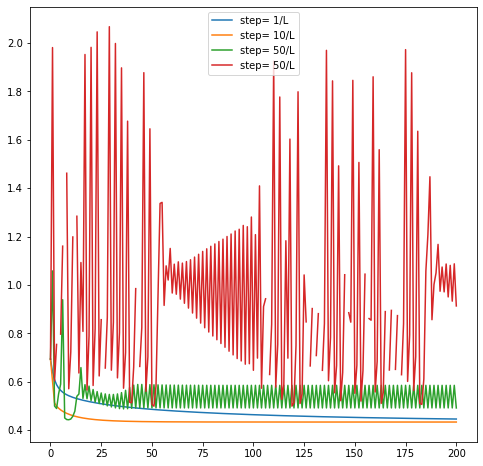

In [61]:
w0 = np.zeros(pb.d).reshape(-1,1)
alpha = 1/pb.lipgrad()
plt.figure(figsize=(8,8))

it, val = descent_constant_step(pb, w0, 200, alpha)
plt.plot(val, label = 'step= '+str(1)+'/L')

it, val = descent_constant_step(pb, w0, 200, 10*alpha)
plt.plot(val, label = 'step= '+str(10)+'/L')

it, val = descent_constant_step(pb, w0, 200, 25*alpha)
plt.plot(val, label = 'step= '+str(50)+'/L')

it, val = descent_constant_step(pb, w0, 200, 50*alpha)
plt.plot(val, label = 'step= '+str(50)+'/L')

plt.legend()

# Accelerated gradient (Nesterov) :

In [62]:
def nag_descent_step(pb,w0,T,alpha):

    d = np.shape(w0)[0]
    iterates = [w0.reshape(1,-1)]
    vals = [pb.fun(w0)]
    y = w0
    w = w0
    w_old = w0
    lam_old = 0
    lam = 0.5*(1+np.sqrt(5))

    s=0
    print(f'Nesterov Gradient descent with step {alpha}')
    start_time = time.time()
    for i in range(T):
        grad = pb.grad(w)
        w = y - alpha*pb.grad(y)
        lam_old = lam
        lam = 0.5*(1+np.sqrt(1+4*lam**2))
        gamma = (lam_old - 1)/lam
        y = w + gamma*(w-w_old)
        w_old = w
        vals.append(pb.fun(w))
        iterates.append(w.reshape(1,-1))
        if s == 0 and np.max(np.abs(grad))<0.05 :
            print(f"Convergence at (Gradient_inf < 0.05): { (time.time() - start_time)} second \n")
            s += 1

    if (s==0):
        print(f'Convergence criteria (Gradient_inf <0.05) not atteigned\n')

    iterates = np.array(iterates).squeeze(1).T
    vals = np.array(vals)
    return iterates, vals

Gradient descent with step 0.4019861049680915
Convergence at (Gradient_inf < 0.05): 0.026929616928100586 second 

Nesterov Gradient descent with step 0.4019861049680915
Convergence at (Gradient_inf < 0.05): 0.009166479110717773 second 



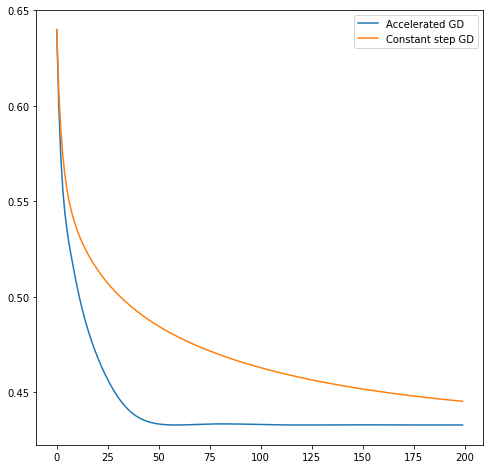

In [63]:
plt.figure(figsize=(8,8))
w0 = np.zeros((X.shape[1],1))
it, val = descent_constant_step(pb, w0, 200, 1/pb.lipgrad())
nag_it, nag_val = nag_descent_step(pb, w0, 200, 1/pb.lipgrad())
plt.plot(nag_val[1:], label = 'Accelerated GD')
plt.plot(val[1:], label = 'Constant step GD')
plt.legend()

# Recap on performance

In [ ]:
print('On the training set')
print(f'\t Accuracy of constant GD (1/L) : {accuracy(X, Y.reshape(-1,1), it[:,-1])}')
print(f'\t Accuracy of accelerated GD (1/L) : {accuracy(X, Y.reshape(-1,1), nag_it[:,-1])}')
print('On the test set')
print(f'\t Accuracy of constant GD (1/L) : {accuracy(X_test, Y_test.reshape(-1,1), it[:,-1])}')
print(f'\t Accuracy of accelerated GD (1/L) : {accuracy(X_test, Y_test.reshape(-1,1), nag_it[:,-1])}')


On the training set
	 Accuracy of constant GD (1/L) : 0.7814285714285714
	 Accuracy of accelerated GD (1/L) : 0.7992857142857143
On the test set
	 Accuracy of constant GD (1/L) : 0.7853107344632768
	 Accuracy of accelerated GD (1/L) : 0.7909604519774012


# Stochastic Gradient descent :

In [72]:
# Stochastic gradient implementation
def stoch_grad(w0,problem,wtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,average=0,scaling=0): 
    """
        A code for gradient descent with various step choices.
        
        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            wtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size 
                1: Classical stochastic gradient algorithm (default value)
                problem.n: Classical gradient descent (default value)
            average: Indicates whether the method computes the average of the iterates 
                0: No averaging (default)
                1: With averaging
            scaling: Use a diagonal scaling
                0: No scaling (default)
                1: Average of magnitudes (RMSProp)
                2: Normalization with magnitudes (Adagrad)
            
        Outputs:
            w_output: Final iterate of the method (or average if average=1)
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    t=0
    print(f'Stochastic Gradient descent with batch size {nb}')
    start_time = time.time()

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    w = w0.copy()
    nw = norm(w)
    
    # Average (if needed)
    if average:
            wavg=np.zeros(len(w))
    
    #Scaling values
    if scaling>0:
        nu=1/(2 *(n ** (0.5)))
        R = np.zeros(d)
        tau = 0.8

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(w) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)
    
    # # Plot initial quantities of interest
    # print("Stochastic Gradient, batch size=",nb,"/",n)
    # print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
    # print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter):
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=False)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],w)
            sg = sg + gi
        sg = (1/nb)*sg
        if t == 0 and np.max(np.abs(sg))<0.05 :
            print(f"Convergence at (Gradient_inf < 0.05): { (time.time() - start_time)} second \n")
            t += 1

        
        if scaling>0:
            if scaling==1:
                #tau = 0.
                R = tau*R + (1-tau)*sg*sg
            elif scaling==2:
                R = R + sg*sg 
            sg = sg/(np.sqrt(R+nu))
            
        if stepchoice==0:
            w[:] = w - (1/L) * sg
        elif stepchoice==1:
            sk = float(step0/(np.sqrt(k+1)))
            w[:] = w - sk * sg
        
        nw = norm(w) #Computing the norm to measure divergence 
        
        if average:
            # If average, compute the average of the iterates
            wavg = k/(k+1) *wavg + w/(k+1) 
            nmin = norm(wavg-wtarget)
            obj = problem.fun(wavg)
        else:
            obj = problem.fun(w)
            nmin = norm(w-wtarget)
        
       
        
        k += 1

        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            # print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        # print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    if average:
        w_output = wavg.copy()
    else:
        w_output = w.copy()
    if (t==0):
            print(f'Convergence criteria (Gradient_inf <0.1) not atteigned\n')
    return w_output, np.array(objvals), np.array(normits)

In [65]:
def second_order_constant_step(pb,w0,T):

    d = np.shape(w0)[0]
    iterates = np.zeros((d,T+1))
    vals = np.zeros(T+1)

    iterates[:,0:1] = w0
    vals[0] = pb.fun(w0)
    w = w0
    for t in range(1,T+1):
        grad = pb.grad(w)
        w = iterates[:,t-1:t] - np.linalg.pinv(pb.hess(w)) @ grad
        iterates[:,t:t+1] = w
        vals[t] = pb.fun(w)
        
    return (iterates,vals)

In [66]:
w0 = np.random.randn(X.shape[1],1)
it, _ = second_order_constant_step(pb, w0, 50000)
w_optimal_second_order = it[:,-1]

In [70]:
wf_optim = w_optimal_second_order
f_optimal = pb.fun(wf_optim)

In [73]:
nb_epochs = 200
n, d = pb.n, pb.d
nbset = 1
# w0 = np.zeros(d)
w0 = w0.reshape(-1)
# Run a - Gradient descent with constant stepsize
w_a, obj_a, nits_a = stoch_grad(w0,pb,wf_optim,stepchoice=0,step0=1, n_iter=nb_epochs,nb=n)

# Run b - Stochastic gradient with constant stepsize
# The version below diverges - The bound on norm(w) in the code will be triggered
w_b, obj_b, nits_b = stoch_grad(w0,pb,wf_optim,stepchoice=0,step0=1, n_iter=int(nb_epochs*n/nbset),nb=1)

Stochastic Gradient descent with batch size 1400
Convergence at (Gradient_inf < 0.05): 3.785747766494751 second 

Stochastic Gradient descent with batch size 1
Convergence at (Gradient_inf < 0.05): 0.006745100021362305 second 



In [74]:
# Compare implementations of gradient descent/stochastic gradient
# Pay attention to the budget allocated to each solver (the cost of one iteration of gradient descent vs 
# the cost of 1 iteration of stochastic gradient are different)

nb_epochs = 200
n = pb.n

# Run c - Gradient descent with decreasing stepsize
w_c, obj_c, nits_c = stoch_grad(w0,pb,wf_optim,stepchoice=1,step0=0.2, n_iter=nb_epochs,nb=n)
# Run d - Stochastic gradient with decreasing stepsize
w_d, obj_d, nits_d = stoch_grad(w0,pb,wf_optim,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1)


Stochastic Gradient descent with batch size 1400
Convergence criteria (Gradient_inf <0.1) not atteigned

Stochastic Gradient descent with batch size 1
Convergence at (Gradient_inf < 0.05): 0.008997201919555664 second 



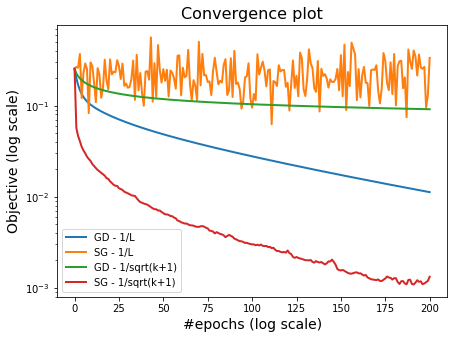

In [ ]:
# Plot the comparison of variants of GD/SG with the same stepsize rule
# NB: The x-axis is in epochs (1 iteration of GD).

# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-pb.fun(wf_optim), label="GD - 1/L", lw=2)
plt.semilogy(obj_b-pb.fun(wf_optim), label="SG - 1/L", lw=2)
plt.semilogy(obj_c-pb.fun(wf_optim), label="GD - 1/sqrt(k+1)", lw=2)
plt.semilogy(obj_d-pb.fun(wf_optim), label="SG - 1/sqrt(k+1)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

# Batch size experimentation :

In [75]:
# Test several values for the batch size using the same epoch budget.

nb_epochs = 200
n = pb.n
w0 = np.zeros(d)
w_min_lin = np.zeros((d,1))

# Stochastic gradient (batch size 1)
w_a, obj_a, nits_a = stoch_grad(w0,pb,wf_optim,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Batch stochastic gradient (batch size n/100)
nbset=int(n/100)
w_b, obj_b, nits_b = stoch_grad(w0,pb,wf_optim,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset)
# Batch stochastic gradient (batch size n/10)
nbset=int(n/10)
w_c, obj_c, nits_c = stoch_grad(w0,pb,wf_optim,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset)
# Batch stochastic gradient (batch size n/2)
nbset=int(n/2)
w_d, obj_d, nits_d = stoch_grad(w0,pb,wf_optim,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset)
# Gradient descent (batch size n)
w_e, obj_e, nits_e = stoch_grad(w0,pb,wf_optim,stepchoice=1,step0=0.2, n_iter=int(nb_epochs),nb=n)

Stochastic Gradient descent with batch size 1
Convergence at (Gradient_inf < 0.05): 0.6913352012634277 second 

Stochastic Gradient descent with batch size 14
Convergence at (Gradient_inf < 0.05): 9.116992235183716 second 

Stochastic Gradient descent with batch size 140
Convergence at (Gradient_inf < 0.05): 0.8742430210113525 second 

Stochastic Gradient descent with batch size 700
Convergence at (Gradient_inf < 0.05): 5.233568429946899 second 

Stochastic Gradient descent with batch size 1400
Convergence criteria (Gradient_inf <0.1) not atteigned



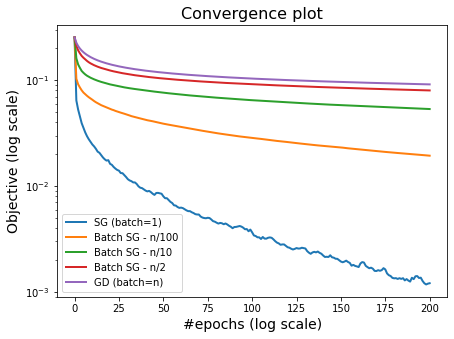

In [ ]:
# Plot the comparison of variants of batch SGD with the same stepsize rule

f_min_lin = pb.fun(wf_optim)

# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG (batch=1)", lw=2)
plt.semilogy(obj_b-f_min_lin, label="Batch SG - n/100", lw=2)
plt.semilogy(obj_c-f_min_lin, label="Batch SG - n/10", lw=2)
plt.semilogy(obj_d-f_min_lin, label="Batch SG - n/2", lw=2)
plt.semilogy(obj_e-f_min_lin, label="GD (batch=n)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

In [76]:
# Comparison of stochastic gradient with and without diagonal scaling

nb_epochs = 200
n = pb.n
w0 = np.zeros(d)

# Stochastic gradient (batch size 1) without diagonal scaling
w_f, obj_f, nits_f = stoch_grad(w0,pb,wf_optim,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Stochastic gradient (batch size 1) with RMSProp diagonal scaling
w_g, obj_g, nits_g = stoch_grad(w0,pb,wf_optim,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1,average=0,scaling=1)
# Stochastic gradient (batch size 1) with Adagrad diagonal scaling - Constant step size
w_h, obj_h, nits_h = stoch_grad(w0,pb,wf_optim,stepchoice=0,step0=0.2, n_iter=nb_epochs*n,nb=1,average=0,scaling=2)
# Stochastic gradient (batch size 1) with Adagrad diagonal scaling - Decreasing step size
w_i, obj_i, nits_i = stoch_grad(w0,pb,wf_optim,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1,average=0,scaling=2)

Stochastic Gradient descent with batch size 1
Convergence at (Gradient_inf < 0.05): 1.3089642524719238 second 

Stochastic Gradient descent with batch size 1
Convergence at (Gradient_inf < 0.05): 0.013015508651733398 second 

Stochastic Gradient descent with batch size 1
Convergence at (Gradient_inf < 0.05): 0.0035228729248046875 second 

Stochastic Gradient descent with batch size 1
Convergence at (Gradient_inf < 0.05): 0.0711982250213623 second 



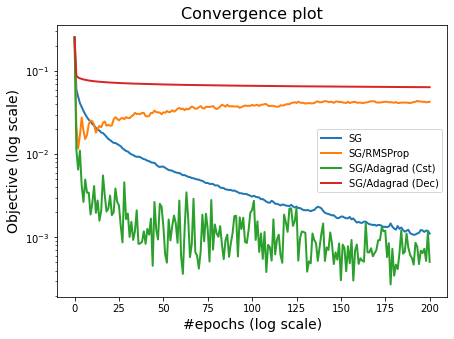

In [ ]:
# Plot the results - Comparison of stochastic gradient with and without diagonal scaling
# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
f_min_lin = pb.fun(wf_optim)
plt.semilogy(obj_f-f_min_lin, label="SG", lw=2)
plt.semilogy(obj_g-f_min_lin, label="SG/RMSProp", lw=2)
plt.semilogy(obj_h-f_min_lin, label="SG/Adagrad (Cst)", lw=2)
plt.semilogy(obj_i-f_min_lin, label="SG/Adagrad (Dec)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

#Recap on performances

In [ ]:
print('On the training set')
print(f'\t Accuracy of stochastic GD bs=1 (1/L) : {accuracy(X, Y.reshape(-1,1), w_a)}')
print(f'\t Accuracy of batch stochastic GD bs=15 (1/L) : {accuracy(X, Y.reshape(-1,1), w_b)}')
print(f'\t Accuracy of batch stochastic GD bs=150 (1/L) : {accuracy(X, Y.reshape(-1,1), w_c)}')
print(f'\t Accuracy of GD (full-batch) (1/L) : {accuracy(X, Y.reshape(-1,1), w_e)}')
print(f'\t Accuracy of Diagonal Scaling SG RMPSProp : {accuracy(X, Y.reshape(-1,1), w_g)}')
print(f'\t Accuracy of Diagonal Scaling SG AdaGrad (Cons) : {accuracy(X, Y.reshape(-1,1), w_h)}')
print('On the test set')
print(f'\t Accuracy of stochastic GD bs=1 (1/L) : {accuracy(X_test, Y_test.reshape(-1,1), w_a)}')
print(f'\t Accuracy of batch stochastic GD bs=15 (1/L) : {accuracy(X_test, Y_test.reshape(-1,1), w_b)}')
print(f'\t Accuracy of batch stochastic GD bs=150 (1/L) : {accuracy(X_test, Y_test.reshape(-1,1), w_c)}')
print(f'\t Accuracy of GD (full-batch) (1/L) : {accuracy(X_test, Y_test.reshape(-1,1), w_e)}')
print(f'\t Accuracy of Diagonal Scaling SG RMPSProp : {accuracy(X_test, Y_test.reshape(-1,1), w_g)}')
print(f'\t Accuracy of Diagonal Scaling SG AdaGrad (Cons) : {accuracy(X_test, Y_test.reshape(-1,1), w_h)}')

On the training set
	 Accuracy of stochastic GD bs=1 (1/L) : 0.7878571428571428
	 Accuracy of batch stochastic GD bs=15 (1/L) : 0.7764285714285715
	 Accuracy of batch stochastic GD bs=150 (1/L) : 0.7585714285714286
	 Accuracy of GD (full-batch) (1/L) : 0.7328571428571429
	 Accuracy of Diagonal Scaling SG RMPSProp : 0.8028571428571428
	 Accuracy of Diagonal Scaling SG AdaGrad (Cons) : 0.7907142857142857
On the test set
	 Accuracy of stochastic GD bs=1 (1/L) : 0.7853107344632768
	 Accuracy of batch stochastic GD bs=15 (1/L) : 0.7740112994350282
	 Accuracy of batch stochastic GD bs=150 (1/L) : 0.7401129943502824
	 Accuracy of GD (full-batch) (1/L) : 0.7401129943502824
	 Accuracy of Diagonal Scaling SG RMPSProp : 0.8192090395480226
	 Accuracy of Diagonal Scaling SG AdaGrad (Cons) : 0.768361581920904


# Lasso Regularization

In [ ]:
def lasso_f(x,Lambda): 
    return f(w) + Lambda*np.linalg.norm(w,1)

def Soft(w,s): 
    return np.maximum( abs(w)-s, np.zeros(w.shape)  ) * np.sign(w)

def ISTA(w,Lambda,tau): 
    return Soft( w-tau*pb.grad(w), Lambda*tau )

In [ ]:
def lasso_descent_constant_step(pb,w0,T,alpha, Lambda):

    d = np.shape(w0)[0]
    iterates = np.zeros((d,T+1))
    vals = np.zeros(T+1)

    iterates[:,0:1] = w0
    vals[0] = pb.lasso_fun(w0, Lambda)
    w = w0
    for t in range(1,T+1):
        grad = pb.grad(w)
        w = ISTA(iterates[:,t-1:t],Lambda,alpha)
        iterates[:,t:t+1] = w
        vals[t] = pb.lasso_fun(w, Lambda)
        
    return (iterates,vals)

In [ ]:
w = []
lambdas = np.arange(0,0.25,0.005)
for lam in lambdas:
    it, val = lasso_descent_constant_step(pb, w0.reshape(-1,1), 200, 1/pb.lipgrad(), lam)
    w.append(it[:,-1])
w = np.array(w)

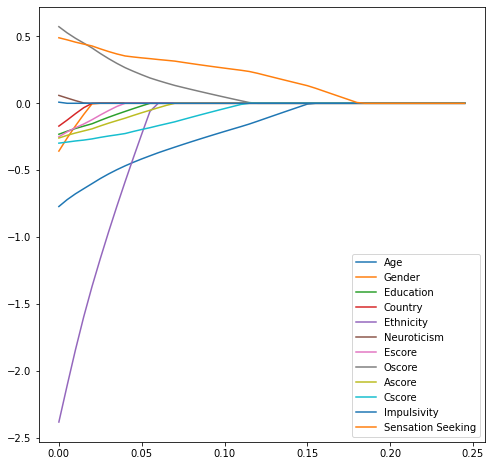

In [ ]:
plt.clf
plt.figure(figsize = (8,8))

for i in range(pb.d):
    plt.plot(lambdas, w[:,i], label = list(df.columns)[i])
plt.legend()

# Analysis:

The lasso regularization does feature selection, and we can get qualitative insight from this graph :
- The gender and Age features are the most indicative of a person's addictiveness, which confirms what we say previously in the data exploration part.
- The Cscore(Conscientiousness) and Oscore (Openness to experience) have the same importance and come approximately in third place.

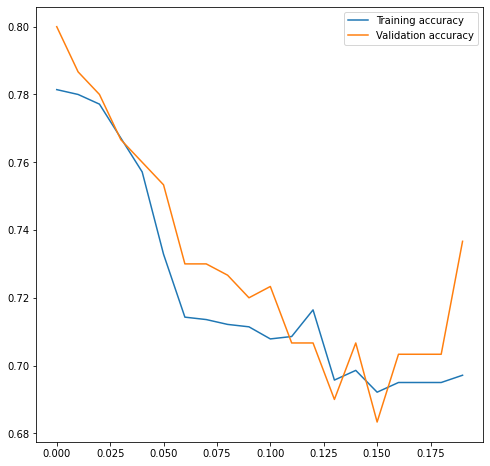

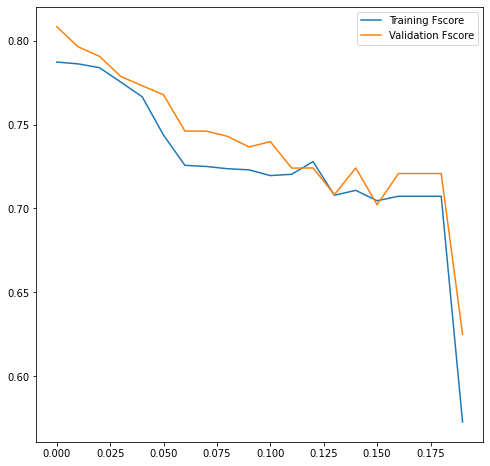

In [ ]:
plt.clf
plt.figure(figsize = (8,8))

accs = []
val_accs = []

fscore = []
val_fscore = []

lambdas = np.arange(0,0.2,0.01)
for lam in lambdas:
    i, v = lasso_descent_constant_step(pb, w0.reshape(-1,1), 200, 1/(pb.lipgrad()), lam)
    accs.append(accuracy(X, Y.reshape(-1,1), i[:,-1]))
    val_accs.append(accuracy(X_val, Y_val.reshape(-1,1), i[:,-1]))
    tmp = predict(X,i[:,-1])
    fscore.append(f1_score(Y, np.array([classify(elt) for elt in tmp]), average='weighted'))
    tmp = predict(X_val,i[:,-1])
    val_fscore.append(f1_score(Y_val, np.array([classify(elt) for elt in tmp]), average='weighted'))

accs = np.array(accs)
val_accs = np.array(val_accs)


plt.plot(lambdas, accs, label = 'Training accuracy')
plt.plot(lambdas, val_accs, label = 'Validation accuracy')

plt.legend()

plt.clf
plt.figure(figsize = (8,8))

plt.plot(lambdas, fscore, label = 'Training Fscore')
plt.plot(lambdas, val_fscore, label = 'Validation Fscore')

plt.legend()


**Analysis**:

We have an unusual setting here where the validation score always outperforms the training score for all values of $\lambda$. As we have a sparse dataset with a relatively small size, one can intuitively think that regularization isn't necessary especially that we have N>>d.

In [ ]:
i, v = lasso_descent_constant_step(pb, w0.reshape(-1,1), 200, 1/(pb.lipgrad()), 0)
izerozerofive, v = lasso_descent_constant_step(pb, w0.reshape(-1,1), 200, 1/(pb.lipgrad()), 0.05)
izeroone, v = lasso_descent_constant_step(pb, w0.reshape(-1,1), 200, 1/(pb.lipgrad()), 0.1)


In [ ]:
print('On the training set')
print(f'\t Accuracy of GD with no regularisation lambda = 0 : {accuracy(X, Y.reshape(-1,1), i[:,-1])}')
print(f'\t Accuracy of GD with lambda = 0.05 : {accuracy(X, Y.reshape(-1,1), izerozerofive[:,-1])}')
print(f'\t Accuracy of GD with lambda = 0.1 : {accuracy(X, Y.reshape(-1,1), izeroone[:,-1])}')
print('On the test set')
print(f'\t Accuracy of GD with no regularisation lambda = 0 : {accuracy(X_test, Y_test.reshape(-1,1), i[:,-1])}')
print(f'\t Accuracy of GD with lambda = 0.05 : {accuracy(X_test, Y_test.reshape(-1,1), izerozerofive[:,-1])}')
print(f'\t Accuracy of GD with lambda = 0.1 : {accuracy(X_test, Y_test.reshape(-1,1), izeroone[:,-1])}')

On the training set
	 Accuracy of GD with no regularisation lambda = 0 : 0.7814285714285714
	 Accuracy of GD with lambda = 0.05 : 0.7328571428571429
	 Accuracy of GD with lambda = 0.1 : 0.7078571428571429
On the test set
	 Accuracy of GD with no regularisation lambda = 0 : 0.7853107344632768
	 Accuracy of GD with lambda = 0.05 : 0.7457627118644068
	 Accuracy of GD with lambda = 0.1 : 0.7401129943502824


# Variance Reduction techniques (SAGA):

In [ ]:
# Stochastic gradient implementation
def saga(w0,problem,wtarget, n_iter=1000): 
    """
        A code for the SAGA algorithm adapted to work with generalized linear models for which
        
        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.grad_xi() returns the gradient of a single component f_i by taking x_i^T*w as argument
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            wtarget: Target minimum (unknown in practice!)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            
        Outputs:
            w_output: Final iterate of the method
            objgap: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    # gradient norm history
    normgrads = []
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz and strong convexity constants
    L = problem.lipgrad()
    
    mu = problem.cvxval()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    w = w0.copy()
    nw = norm(w)

    # Initialize iteration counter
    k=0
    
    # Steplength
    alpha = 0.2/(mu*n+L)
    
    # Current objective
    obj = problem.fun(w) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)
    
    # # Plot initial quantities of interest
    # print("SAGA")
    # print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
    # print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    
    # Initial gradient calculation
    gavg = np.zeros(d)
    Xw = problem.X.dot(w)
    for i in range(n):
        gavg[:] = gavg + problem.grad_xi(i,Xw[i])
    
    gavg = (1/n)*gavg
    
    ################
    # Main loop
    while (k < n_iter and nw < 10**100):
        
        ik = np.random.choice(n,1,replace=True) # Stochastic gradient (1 component)
        xikw = problem.X[ik].dot(w)
        tp = problem.grad_xi(ik,xikw) - problem.grad_xi(ik,Xw[ik])
        sg = tp + gavg
        gavg = gavg + (1/n) * tp
        Xw[ik]=xikw #Update average
        w[:] = w - alpha * sg
        nw = norm(w) #Computing the norm to measure divergence 
        obj = problem.fun(w)
        nmin = norm(w-wtarget)
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if k % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            # print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if k % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        # print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    w_output = w.copy()
    return w_output, np.array(objvals), np.array(normits)

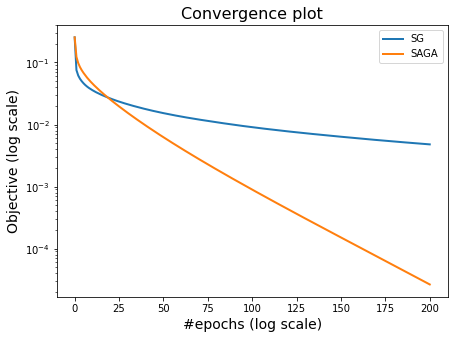

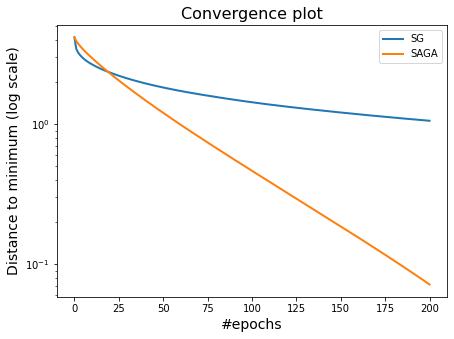

In [ ]:
nb_epochs = 200
n = pb.n
w0 = np.zeros(d)
m = 5

f_min_lin = pb.fun(wf_optim)

# Stochastic gradient (batch size 1) without averaging
w_a, obj_a, nits_a = stoch_grad(w0,pb,wf_optim,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,average=1)
# SAGA
w_c, obj_c, nits_c = saga(w0,pb,wf_optim,n_iter=nb_epochs*n)

# Plot the results
# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG", lw=2)
plt.semilogy(obj_c-f_min_lin, label="SAGA", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
# In terms of gradient norm (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(nits_a, label="SG", lw=2)
plt.semilogy(nits_c, label="SAGA", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Distance to minimum (log scale)", fontsize=14)
plt.legend()

In [ ]:
print('On the training set')
print(f'\t Accuracy of GD with no regularisation lambda = 0 : {accuracy(X, Y.reshape(-1,1), w_a)}')
print(f'\t Accuracy of SAGA : {accuracy(X, Y.reshape(-1,1), w_c)}')
print('On the test set')
print(f'\t Accuracy of GD with no regularisation lambda = 0 : {accuracy(X_test, Y_test.reshape(-1,1), w_a)}')
print(f'\t Accuracy of SAGA : {accuracy(X_test, Y_test.reshape(-1,1), w_c)}')

On the training set
	 Accuracy of GD with no regularisation lambda = 0 : 0.7857142857142857
	 Accuracy of SAGA : 0.7978571428571428
On the test set
	 Accuracy of GD with no regularisation lambda = 0 : 0.7740112994350282
	 Accuracy of SAGA : 0.7909604519774012


# Second order Method (Newton-Raphson)

In [144]:
def second_order_constant_step(pb,w0,T):

    print(f'Second order method (Newton-Raphson)\n')
    d = np.shape(w0)[0]
    iterates = np.zeros((d,T+1))
    vals = np.zeros(T+1)

    iterates[:,0:1] = w0
    vals[0] = pb.fun(w0)
    w = w0
    start_time = time.time()
    s = 0
    for t in range(1,T+1):
        grad = pb.grad(w)
        if s == 0 and np.max(np.abs(grad))<0.05 :
            print(f'Convergence at (Gradient_inf < 0.05): { (time.time() - start_time)} second \n')
            s += 1
        w = iterates[:,t-1:t] - np.linalg.inv(pb.hess(w)) @ grad
        iterates[:,t:t+1] = w
        vals[t] = pb.fun(w)
        
    if s == 0:
        print(f'Convergence criteria (Gradient_inf <0.05) not atteigned\n')

    return (iterates,vals)

Second order method (Newton-Raphson)

Convergence at (Gradient_inf < 0.05): 3.1042654514312744 second 



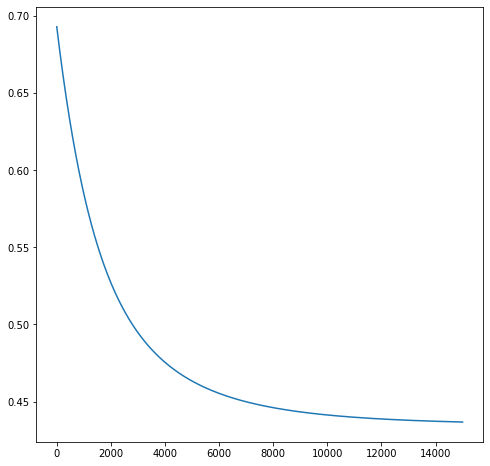

In [147]:

plt.figure(figsize=(8,8))
it, val = second_order_constant_step(pb, w0.reshape(-1,1), 15000)
plt.plot(val)

In [ ]:
print('On the training set')
print(f'\t Accuracy of GD with Newton-Raphton method : {accuracy(X, Y.reshape(-1,1), it[:,-1])}')
print('On the test set')
print(f'\t Accuracy of GD with Newton-Raphton method: {accuracy(X_test, Y_test.reshape(-1,1), it[:,-1])}')

On the training set
	 Accuracy of GD with Newton-Raphton method : 0.7985714285714286
On the test set
	 Accuracy of GD with Newton-Raphton method: 0.7966101694915254


# Analysis :
The algorithm is very slow compared to the other algorithms, normally, we have a quadratic convergence guarantee, however, we do not witness this rate here. It might be an odd setting in which the convergence is slower than usual.

Second order methods are not necessary here and are rather impractical as they recquire a high memory overload.